In [6]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

new_map = {'1, 50000': "#ffef40",
         '1, 70000': "#ff9f40",
         '1, 100000': "#ff6040",
         '2, 50000': "#6fff5c",
         '2, 70000': "#4ef5aa",
         '2, 100000': "#4ee1f5",
         '4, 50000': "#864ef5",
         '4, 70000': "#bb4ef5",
         '4, 1000000': "#ed5cdf",
          }

files = ['../../../data/out_metrics/results_20250111_230040_lay_act_0_4.pkl',
         '../../../data/out_metrics/results_20250110_235015_lay_act_4_8.pkl',
         '../../../data/out_metrics/results_20250111_141338_lay_act_8_12.pkl',
        '../../../data/out_metrics/results_20250111_073045_lay_act_12_16.pkl',
        '../../../data/out_metrics/results_20250113_231645_lay_act_15_16.pkl',
         '../../../data/out_metrics/results_20250112_141019_lay_act_16_20.pkl',
         '../../../data/out_metrics/results_20250113_032700_lay_act_20_24.pkl',
        ]

In [7]:
!ls ../../../data/out_metrics/*202412*lay_act*12_16*

../../../data/out_metrics/results_20241203_125550_lay_act_12_16.pkl
../../../data/out_metrics/results_20241204_084350_lay_act_12_16.pkl
../../../data/out_metrics/results_20241205_070611_lay_act_12_16.pkl


In [64]:
all_results = dict()
for file_name in files:
    with open(file_name.replace('results', 'losses'), "rb") as file:
        results = dict(pickle.load(file))
    all_results = {**all_results, **results}
    
print(f"Amount of sets: {len(all_results)}")

# Flatten the data while preserving the structure from the tuple keys
flattened_data = {
    "activation_function": [],
    "num_layers": [],
    "n_rows": [],
    "iteration": [],
    "epochs": [],
    "values": []
}

# Iterate over each dataset size, activation function, and number of layers
for (n_rows, act_fn, n_layers), list_of_iterations in all_results.items():
    # For each iteration in the dataset size
    for i, iteration_list in enumerate(list_of_iterations):
        # Flatten the iteration list with epochs multiplied by 2 (0, 2, 4, ..., 18)
        for epoch, value in enumerate(iteration_list):
            cur_act_fn = act_fn
            if act_fn == 'default':
                cur_act_fn = "default"
            flattened_data["activation_function"].append(cur_act_fn)
            flattened_data["num_layers"].append(n_layers)
            flattened_data["n_rows"].append(n_rows)
            flattened_data["iteration"].append(i)
            flattened_data["epochs"].append((epoch+1))
            flattened_data["values"].append(value)

# Convert to DataFrame for plotting
results_melted = pd.DataFrame(flattened_data)
results_melted.activation_function = results_melted.activation_function.apply(lambda x: {'default': "ReLU", 'GELU':'GELU', 'RAF':"RReLU", 'softmax':'softmax'}[x])
results_melted
# pd.DataFrame(all_results).T

Amount of sets: 24


,activation_function,num_layers,n_rows,iteration,epochs,values
0,ReLU,1,50000,0,1,8.202338
1,ReLU,1,50000,0,2,6.982879
2,ReLU,1,50000,0,3,6.751331
3,ReLU,1,50000,0,4,6.181173
4,ReLU,1,50000,0,5,4.806356
...,...,...,...,...,...,...
239995,softmax,4,70000,9,996,0.146120
239996,softmax,4,70000,9,997,0.145711
239997,softmax,4,70000,9,998,0.145696
239998,softmax,4,70000,9,999,0.145870


In [65]:
def draw_acc_epochs(results_melted, cur_cutoff, layer_color_map):
    cur_results_melted = results_melted[results_melted.epochs<=cur_cutoff].rename(columns={"n_rows": "data size", 
                                                                                           "n_rows, num_layers": "data size, layers amount",
                                                                                          "activation_function": "activation function"})

    # Plot with Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(9, 5))

    sns.lineplot(
        data=cur_results_melted ,
        x="epochs",
        y="values",
        hue="data size, layers amount",  # Combined hue for Num_Layers and N_rows
        style="activation function",
        palette=layer_color_map,  # Ensure this supports the combined categories
        linewidth=1,
    )

    plt.xlim(0, cur_cutoff)

    # Add labels and legend
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Mean loss with standard deviation per epoch of training\nfor different data sizes, activation functions, and layers amount")
    plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [66]:
# Generate unique colors for each Num_Layers value
unique_layers = results_melted['num_layers'].unique()
layer_palette = sns.color_palette("Set2", len(unique_layers))
layer_color_map = {layer: color for layer, color in zip(unique_layers, layer_palette)}

results_melted['n_rows, num_layers'] = results_melted['num_layers'].astype(str) + ", " + results_melted['n_rows'].astype(str)  
unique_hues = sorted(results_melted['n_rows, num_layers'].unique())
layer_color_map = {hue: sns.color_palette("Paired")[i % 10] for i, hue in enumerate(unique_hues)}


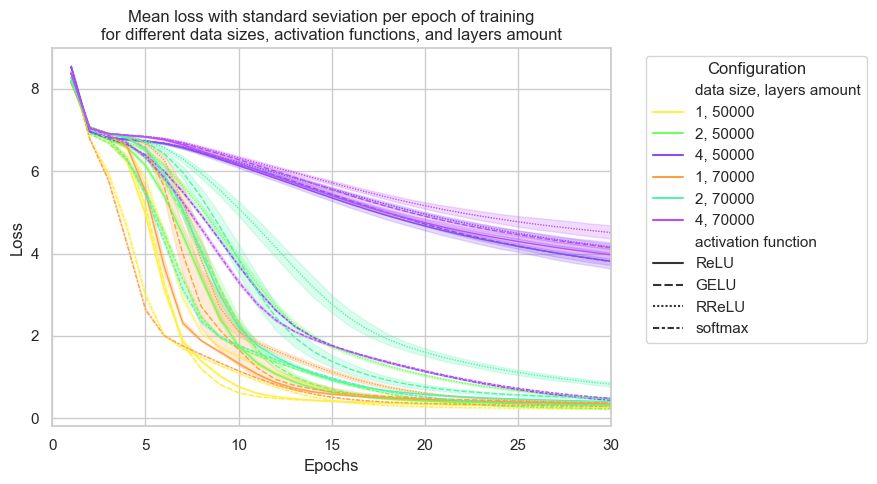

In [67]:
draw_acc_epochs(results_melted, 30, new_map)

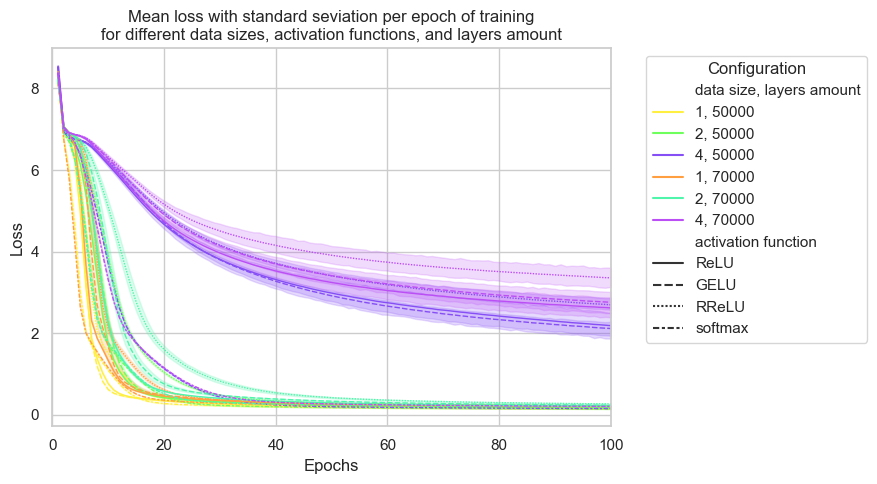

In [68]:
draw_acc_epochs(results_melted, 100, new_map)

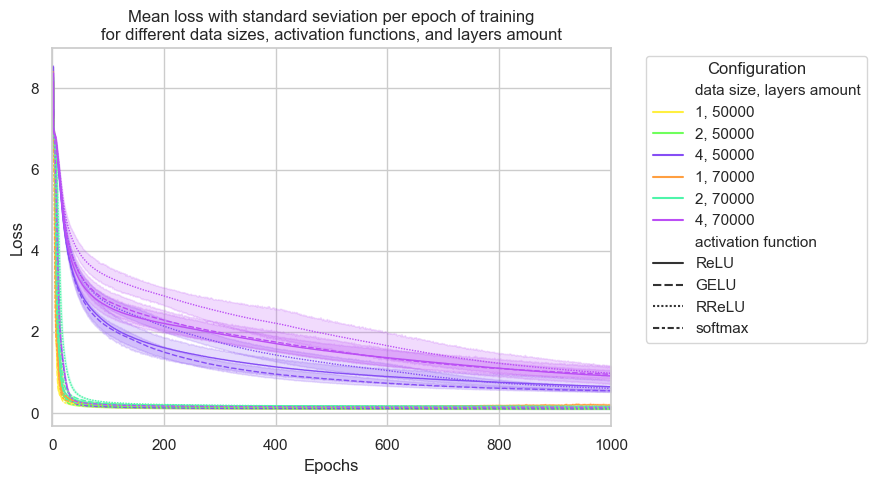

In [69]:
draw_acc_epochs(results_melted, results_melted.epochs.max(), new_map)

## Violins

In [19]:
data_viol = results_melted[results_melted.epochs == max(results_melted.epochs)]
data_viol.head()

,activation_function,num_layers,n_rows,iteration,epochs,values,"n_rows, num_layers"
999,ReLU,1,50000,0,2000,0.120747,"1, 50000"
1999,ReLU,1,50000,1,2000,0.116492,"1, 50000"
2999,ReLU,1,50000,2,2000,0.121219,"1, 50000"
3999,ReLU,1,50000,3,2000,0.118949,"1, 50000"
4999,ReLU,1,50000,4,2000,0.127584,"1, 50000"


In [42]:
list(new_map.values())

['#ffef40',
 '#ff9f40',
 '#ff6040',
 '#6fff5c',
 '#4ef5aa',
 '#4ee1f5',
 '#864ef5',
 '#bb4ef5',
 '#ed5cdf']

In [70]:
def draw_violins(data_viol, x, y, xlabel, ylabel, title, hue=None, return_ax=False, ax=None):
    PALETTE_PARAMS = "Accent"
    PALETTE = "Set2"
    data_dict = {"x":x,
            "y":y,
            "palette":list(new_map.values())[::3],
            "alpha":0.7,
            "linewidth":0.5}
    if hue:
        data_dict["hue"] = hue
        data_dict["dodge"] = True
    if ax:
        data_dict["ax"] = axs[col]
    ax = sns.stripplot(
        data_viol,
        **data_dict,
        legend=True
        
    )
    ax = sns.violinplot(
        data_viol,
        **data_dict,
        cut=0,
        legend=False, 
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if return_ax:
        return ax

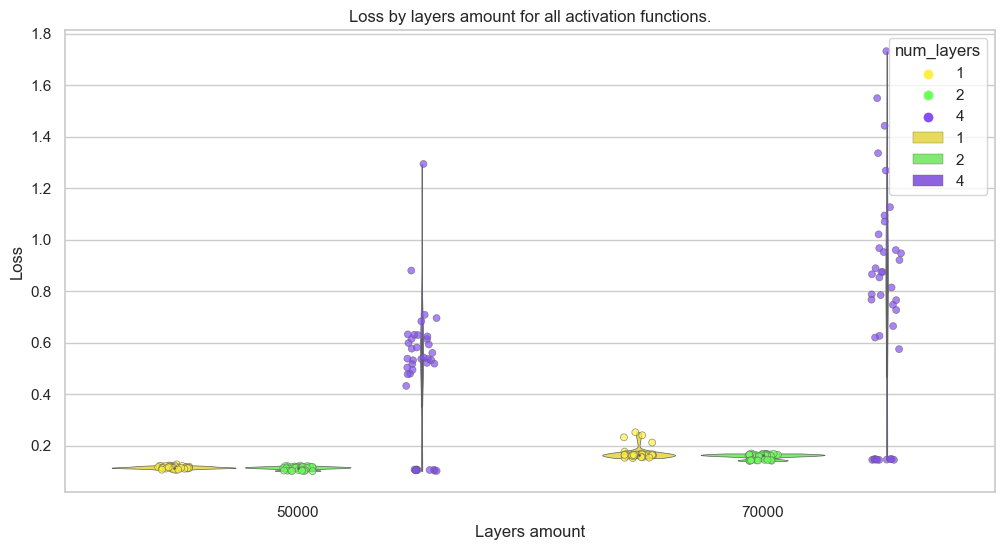

In [71]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
draw_violins(
    data_viol,
    x="n_rows",
    y="values",
    xlabel="Layers amount",
    ylabel="Loss",
    title="Loss by layers amount for all activation functions.",
    hue="num_layers"
)

<Figure size 1400x400 with 0 Axes>

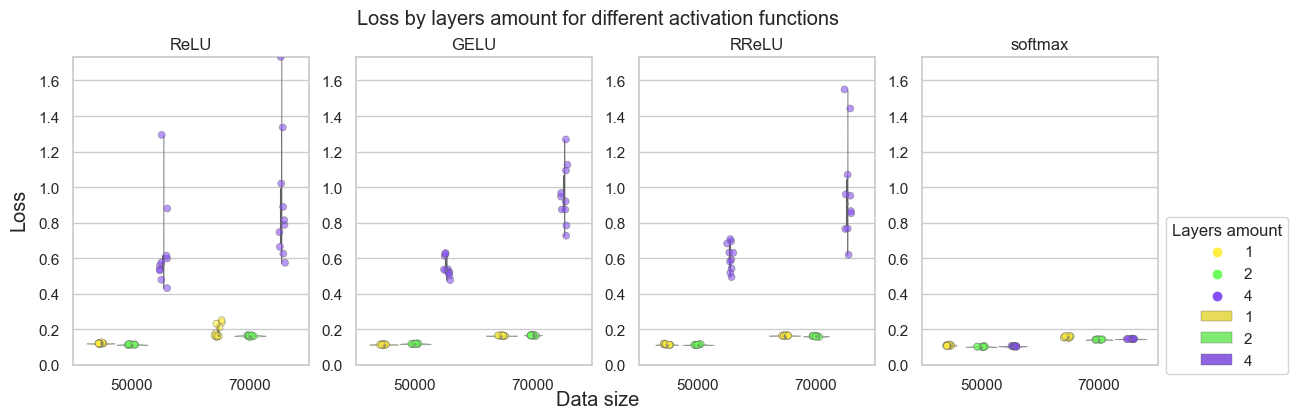

In [72]:
sns.set(rc={"figure.figsize": (14, 4)})
sns.set_theme(style="whitegrid")
# get legend
ax = draw_violins(
        data_viol,
        x="n_rows",
        y="values",
        xlabel="Layers amount",
        ylabel="Accuracy, %",
        title=f"Accuracy by layers amount.",
        hue="num_layers",
        return_ax=True,
    )
handles, labels = ax.get_legend_handles_labels()
plt.clf()
# draw
fig, axs = plt.subplots(nrows=1, ncols=4)
for i, act_f in enumerate(data_viol.activation_function.unique()):
    row = i // 4
    col = i % 4
    cur_data = data_viol[data_viol.activation_function==act_f]
    ax = draw_violins(
        cur_data,
        x="n_rows",
        y="values",
        xlabel="Layers amount",
        ylabel="Loss",
        title=f"`{act_f}`.",
        hue="num_layers",
        return_ax=True,
        ax=axs[col], 
        
    )
    plt.setp(ax.collections, alpha=.58)
    ax.legend_.remove()
    ax.set(ylabel="", xlabel="", title=act_f)
    ax.set(ylim=(0, data_viol['values'].max()))
    ax
fig.supylabel("Loss", y=0.5, x=0.08)
fig.supxlabel("Data size", y=0, x=0.5)
fig.suptitle("Loss by layers amount for different activation functions", y=1, x=0.5)
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.9, 0.5), title='Layers amount')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)
plt.show()